In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

from lib.data_preparation import DataPreparation
from lib.preprocessing_data import Preprocessing


data_set = DataPreparation().load_data()
data_set = Preprocessing().lemmatization(data_set)

data_set = data_set.sample(frac=0.02).reset_index(drop=True)
processed_tweets = data_set['processed_tweet']

# for sentiment, tweet in zip(data_set['sentiment'], data_set['processed_tweet']):
#     print(f"{sentiment}: {tweet}")


negative: ['eat', 'jenna', 'block', 'unhappy']
positive: ['let', 'know', 'you', 'd', 'like', 'one', 'happy']
neutral: ['will', 'not', 'allow', 'barrage', 'name', 'say']
positive: ['national', 'bitbucket', 'unfriending', 'day', 'save', 'smile']
negative: ['I', 'm', 'hungry', 'unhappy']
negative: ['youngjae', 'look', 'sad', 'video', 'unhappy']
positive: ['rt', 'almightytanner', 'good', 'evening', 'everyone', 'happy', 'join', 'twitter', 'party', 'tonight', 'official', 'taglinetann', 'welcomeb']
positive: ['share', 'love', 'high', 'value', 'member', 'week', 'happy', 'insight']
positive: ['share', 'love', 'thank', 'top', 'new', 'follower', 'week', 'happy', 'want']
positive: ['happy']
negative: ['absorb', 'I', 'm', 'go', 'get', 'laugh', 'get', 'vote', 'unhappy']
positive: ['play', 'part', 'raise', 'fund']
positive: ['love', 'happy']
negative: ['ally', 'unhappy', 'can', 'not', 'make', 'poem', 'cute']
negative: ['umma', 'cry']
positive: ['haha', 'would', 'love', 'work', 'train', 'company', 'gr

In [17]:
# Create vocabulary

vocab = set(word for tweet in processed_tweets for word in tweet)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)


In [18]:
import numpy as np
embedding_size = 71
learning_rate = 0.01
# Initialize embeddings
main_embeddings = np.random.normal(0, 0.1, (vocab_size, embedding_size))
context_embeddings = np.random.normal(0, 0.1, (vocab_size, embedding_size))

In [20]:
def sigmoid(x):
    # Numerically stable sigmoid function
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

In [21]:
def normalize_embeddings(embeddings):
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms

In [22]:
def get_negative_samples(vocab_size, exclude_idx, num_samples, word_freq):
    """Sample negative examples based on word frequencies."""
    probabilities = np.array([freq ** 0.75 for freq in word_freq])
    probabilities /= probabilities.sum()

    negative_samples = []
    while len(negative_samples) < num_samples:
        sampled_idx = np.random.choice(vocab_size, p=probabilities)
        if sampled_idx != exclude_idx:
            negative_samples.append(sampled_idx) 
    return negative_samples

In [23]:
def update_embeddings(center_idx, context_idx, label):
    # Update embeddings for one center-context pair
    center_vector = main_embeddings[center_idx]
    context_vector = context_embeddings[context_idx]

    dot_product = np.dot(center_vector, context_vector)
    prediction = sigmoid(dot_product)
    error = label - prediction

    # Gradient updates
    grad_center = error * context_vector
    grad_context = error * center_vector

    main_embeddings[center_idx] += learning_rate * grad_center
    context_embeddings[context_idx] += learning_rate * grad_context

In [24]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine


def plot_words(word1, word2, word_to_index, main_embeddings, context_embeddings):
    """
    Visualize the embeddings of two words in the main and context embedding spaces.
    """
    plt.figure(figsize=(12, 6))

    # Subplot 1: Main embeddings
    plt.subplot(1, 2, 1)
    vector1_main = main_embeddings[word_to_index[word1]]
    vector2_main = main_embeddings[word_to_index[word2]]

    # Plot vector1
    plt.scatter(vector1_main[0], vector1_main[1], color='red', label=word1)
    plt.arrow(0, 0, vector1_main[0], vector1_main[1], head_width=0.00, length_includes_head=True, color='red')
    plt.text(vector1_main[0] * 1.1, vector1_main[1] * 1.1, word1, fontsize=12)

    # Plot vector2
    plt.scatter(vector2_main[0], vector2_main[1], color='blue', label=word2)
    plt.arrow(0, 0, vector2_main[0], vector2_main[1], head_width=0.00, length_includes_head=True, color='blue')
    plt.text(vector2_main[0] * 1.1, vector2_main[1] * 1.1, word2, fontsize=12)

    similarity_main = 1 - cosine(vector1_main, vector2_main)
    plt.title(f"Main Embeddings (Similarity = {round(similarity_main, 4)})", fontsize=4)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.grid()
    plt.legend()

    # Subplot 2: Main vs. Context embeddings
    plt.subplot(1, 2, 2)
    vector1_context = context_embeddings[word_to_index[word1]]
    vector2_context = context_embeddings[word_to_index[word2]]

    # Plot vector1
    plt.scatter(vector1_main[0], vector1_main[1], color='red', label=f"{word1} (Main)")
    plt.arrow(0, 0, vector1_main[0], vector1_main[1], head_width=0.00, length_includes_head=True, color='red')
    plt.text(vector1_main[0] * 1.1, vector1_main[1] * 1.1, f"{word1} (Main)", fontsize=12)

    # Plot vector2 from context
    plt.scatter(vector2_context[0], vector2_context[1], color='green', label=f"{word2} (Context)")
    plt.arrow(0, 0, vector2_context[0], vector2_context[1], head_width=0.00, length_includes_head=True, color='green')
    plt.text(vector2_context[0] * 1.1, vector2_context[1] * 1.1, f"{word2} (Context)", fontsize=12)

    similarity_context = 1 - cosine(vector1_main, vector2_context)
    plt.title(f"Main vs. Context (Similarity = {round(similarity_context, 4)})", fontsize=14)
    plt.axvline(0, color='gray')
    plt.axhline(0, color='gray')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [25]:
def plot_words2(word1, word2, word_to_index, main_embeddings, context_embeddings):
    plt.figure(figsize=(8,4))
    import pandas as pd
    plt.subplot(1,2,1)
    lim_main_first = pd.DataFrame(main_embeddings[word_to_index[word1]])
    lim_main_second = pd.DataFrame(main_embeddings[word_to_index[word2]])
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings[word_to_index[word1]], main_embeddings[word_to_index[word2]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    ###################################
    
    # plt.subplot(1,2,2)
    # lim_main = main_embeddings.loc[[debug[0]]]
    # lim_context = context_embeddings.loc[[debug[1]]]
    # p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    # plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    # for idx,row in lim_main.iterrows():
    #     plt.text(row[0], row[1], str(idx))
    # p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    # plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    # for idx,row in lim_context.iterrows():
    #     plt.text(row[0], row[1], str(idx))
    # sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    # plt.title('Sim = %s'%round(sim,4), fontsize=20)
    # plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    # plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    # plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    plt.show()

In [26]:
def plot_words2(word1, word2, word_to_index, main_embeddings, context_embeddings):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.spatial.distance import cosine

    plt.figure(figsize=(8, 4))

    # Subplot 1: Main embeddings
    plt.subplot(1, 2, 1)
    vector1_main = main_embeddings[word_to_index[word1]]
    vector2_main = main_embeddings[word_to_index[word2]]

    # Plot vectors for word1 and word2
    plt.scatter(vector1_main[0], vector1_main[1], color='red', label=word1)
    plt.arrow(0, 0, vector1_main[0], vector1_main[1], color='red', head_width=0.00, length_includes_head=True)
    plt.text(vector1_main[0] * 1.1, vector1_main[1] * 1.1, word1, fontsize=10)

    plt.scatter(vector2_main[0], vector2_main[1], color='blue', label=word2)
    plt.arrow(0, 0, vector2_main[0], vector2_main[1], color='blue', head_width=0.00, length_includes_head=True)
    plt.text(vector2_main[0] * 1.1, vector2_main[1] * 1.1, word2, fontsize=10)

    # Add similarity as title
    similarity_main = 1 - cosine(vector1_main, vector2_main)
    plt.title(f"Main Embeddings (Sim = {round(similarity_main, 4)})", fontsize=12)

    # Add gridlines and axes
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.grid()

    # Set zoomed-in axis limits
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)

    # Add optional unit circle reference
    t = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(t), np.sin(t), linewidth=0.5, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


Epoch 1/50 completed


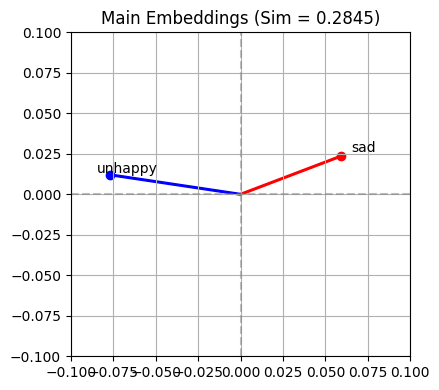

Epoch 2/50 completed
Epoch 3/50 completed
Epoch 4/50 completed
Epoch 5/50 completed
Epoch 6/50 completed


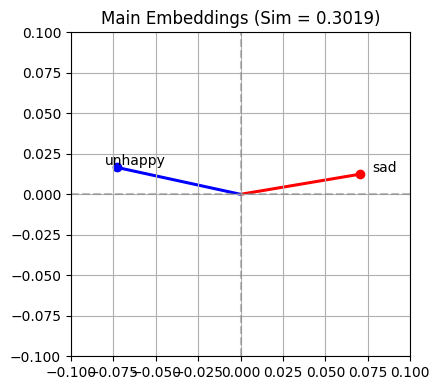

Epoch 7/50 completed
Epoch 8/50 completed
Epoch 9/50 completed
Epoch 10/50 completed
Epoch 11/50 completed


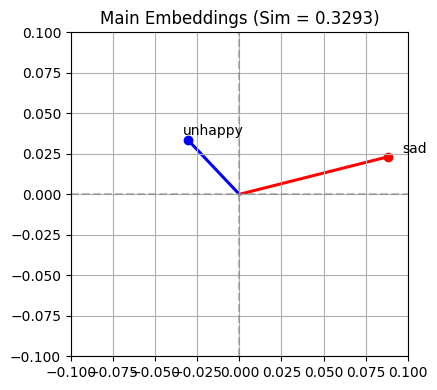

Epoch 12/50 completed
Epoch 13/50 completed
Epoch 14/50 completed
Epoch 15/50 completed
Epoch 16/50 completed


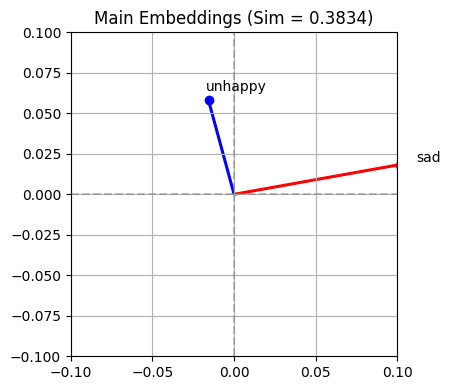

Epoch 17/50 completed
Epoch 18/50 completed
Epoch 19/50 completed
Epoch 20/50 completed
Epoch 21/50 completed


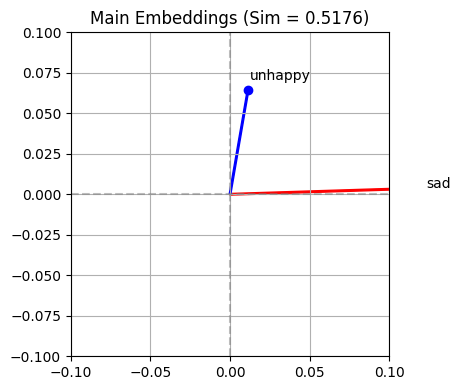

Epoch 22/50 completed
Epoch 23/50 completed
Epoch 24/50 completed
Epoch 25/50 completed
Epoch 26/50 completed


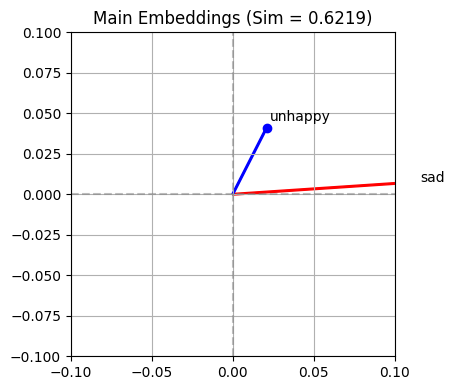

Epoch 27/50 completed
Epoch 28/50 completed
Epoch 29/50 completed
Epoch 30/50 completed
Epoch 31/50 completed


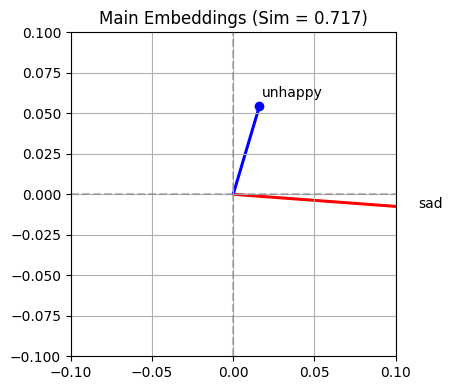

Epoch 32/50 completed
Epoch 33/50 completed
Epoch 34/50 completed
Epoch 35/50 completed
Epoch 36/50 completed


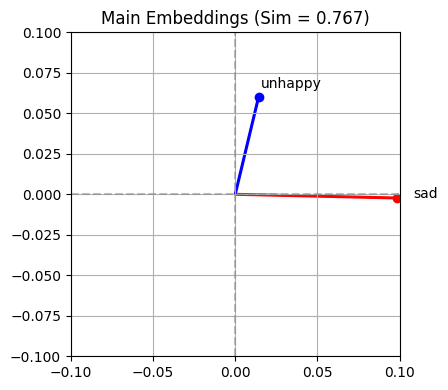

Epoch 37/50 completed
Epoch 38/50 completed
Epoch 39/50 completed
Epoch 40/50 completed
Epoch 41/50 completed


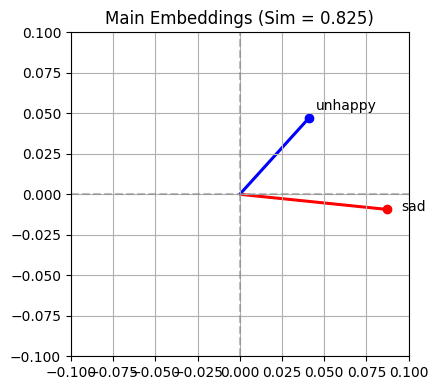

Epoch 42/50 completed
Epoch 43/50 completed
Epoch 44/50 completed
Epoch 45/50 completed
Epoch 46/50 completed


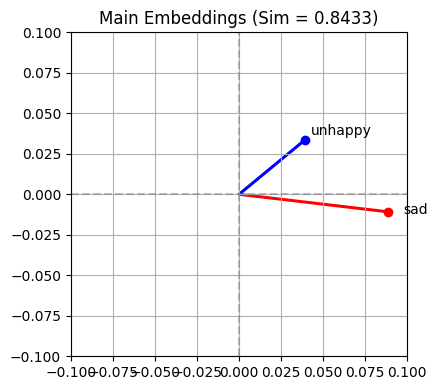

Epoch 47/50 completed
Epoch 48/50 completed
Epoch 49/50 completed
Epoch 50/50 completed


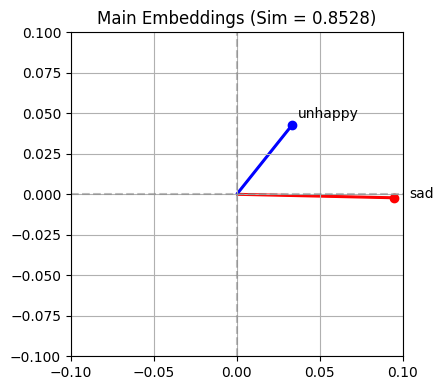

In [28]:
from collections import Counter

word_counts = Counter(word for tweet in processed_tweets for word in tweet)
word_freq = np.array([word_counts[word] for word in vocab])

epochs = 50
window_size = 3
num_negative_samples=3
# Training Loop
# Training Loop
for epoch in range(epochs):
    for tweet in processed_tweets:
        for center_idx, center_word in enumerate(tweet):
            center_word_idx = word_to_idx[center_word]
            start = max(center_idx - window_size, 0)
            end = min(center_idx + window_size + 1, len(tweet))

            for context_idx in range(start, end):
                if center_idx == context_idx:
                    continue
                context_word_idx = word_to_idx[tweet[context_idx]]

                # Positive sample
                update_embeddings(center_word_idx, context_word_idx, 1)
                # Negative samples
                negative_samples = get_negative_samples(vocab_size, center_word_idx, num_negative_samples, word_freq)
                for negative_idx in negative_samples:
                    update_embeddings(center_word_idx, negative_idx, 0)

    # Normalize embeddings after each epoch
    main_embeddings = normalize_embeddings(main_embeddings)
    context_embeddings = normalize_embeddings(context_embeddings)

    # Plot embeddings at the end of every epoch (optional)
    print(f"Epoch {epoch + 1}/{epochs} completed")
    if epoch % 5 == 0:
        plot_words2('sad', 'unhappy', word_to_idx, main_embeddings, context_embeddings)

# Final visualization
plot_words2('sad', 'unhappy', word_to_idx, main_embeddings, context_embeddings)

